In [1]:
import pandas as pd
import numpy as np
from pynm.pynm import PyNM
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sp

# **Multivariate Confounds**

In this tutorial we'll look at using the Gaussian Process (GP) model to overcome two of the limitations of the LOESS & Centiles models we encountered in the previous tutorial:
- Handling missing data
- Modeling datasets with multivariate confounds

## **Gaussian Processes**
Gaussian Processes (GPs) are a probabilistic approach to regression that allow us to have a Confidence Interval (CI) for the prediction.

From Kilian Weinberger's [Cornell lecture](https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote15.html):

> **Definition**: A GP is a (potentially infinte) collection of random variables (RV) such that the joint distribution of every finite subset of RVs is multivariate Gaussian.

A full discussion is beyond the scope of this tutorial, but we can get by with some key points:

- GPs are a form of Bayesian inference and a prior needs to be specified. The prior mean is taken to be 0, and the prior covariance is specified using kernels.
- The kernel used in the PyNM implementation is composed of the Matern kernel plus a constant kernel and a white noise kernel.
- Data must meet the model assumptions (notably homoskedasticity & gaussian noise) for prediction & CIs to be reliable.
- GPs don't scale well to large datasets (cubic complexity in data size).
    - Recommended cutoff for dataset size with PyNM is 2000 subjects


For those who are looking for a deeper introduction there are resources provided at the end of the tutorial.


## **Example 1**
First we'll revisit the dataset from the previous tutorial to illustrate how the GP model deals with missing data compared to the LOESS & Centiles models.

Here we are using a dataset with:
- A single explanatory variable (age)
- Homoskedastic variance across the explanatory variable
- Gaussian noise
- A random offset in score for probands pulled from the gaussian distribution

In [2]:
# Define Functions
def sample_x(low=1,high=100,n_subs=1000,sampling='full'):
    if sampling =='full':
        x = np.random.uniform(low=low,high=high,size=n_subs)
    else:
        x = np.concatenate([np.random.normal(20,10,size=int(n_subs/2)),np.random.normal(80,10,size=int(n_subs/2))])
        x = x[(x<high) & (x > low)]
    return x

def f(x):
    return 2*np.log(x) + np.random.randn()

def dataset(seed=10,sampling='full'):
    # Set seed
    np.random.seed(seed)

    # Age param
    x = np.sort(sample_x(sampling=sampling))

    # PROB = 1/CTR = 0
    status1 =  np.random.binomial(1,0.2,size=(int(0.75*x.shape[0])))
    status2 =  np.random.binomial(1,0.07,size=(x.shape[0] - status1.shape[0]))
    status = np.concatenate([status1, status2])

    # Score param
    score = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        s = f(x[i])

        # Random offset for probands
        s = s + status[i]*np.random.normal(0.7,1)

        score[i] = s

    return pd.DataFrame([x,status,score],index=['age','status','score']).transpose()

<AxesSubplot:xlabel='age', ylabel='score'>

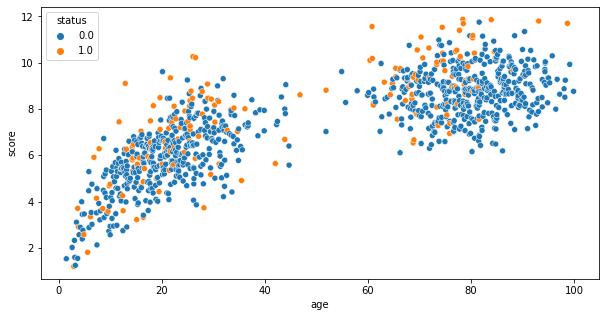

In [3]:
# Create a dataset
df_gap = dataset(sampling='gap')

# Visualize data
# PROB = 1/CON = 0
plt.figure(figsize=(10,5))
sns.scatterplot(x='age',y='score',hue='status',data=df_gap)

### Fit GP model with single confound on missing data

In [4]:
# Initialize pynm object w/ data and confound, & bin parameters
m_gap = PyNM(df_gap,'score','status',['age'],bin_spacing=1,bin_width=3)

# Run models
m_gap.loess_normative_model()
m_gap.centiles_normative_model()
m_gap.gp_normative_model()

Models will be fit on full set of controls.


/home/harveyaa/Documents/masters/PyNM/pynm/models/centiles.py:63: RuntimeWarning: invalid value encountered in greater_equal
  max_mask = test_data[:,1] >= np.max(centiles, axis=1)
/home/harveyaa/Documents/masters/PyNM/pynm/models/centiles.py:64: RuntimeWarning: invalid value encountered in less
  min_mask = test_data[:,1] < np.min(centiles, axis=1)
/home/harveyaa/Documents/masters/PyNM/pynm/models/centiles.py:68: RuntimeWarning: invalid value encountered in greater_equal
  result[else_mask] = np.array([np.argmin(test_data[:,1][i] >= centiles[i]) for i in range(test_data.shape[0])])[else_mask]


We can see in the plot below that the GP model makes predictions smoothly in the region with missing data, with a slight decrease in confidence (widening of the CI). This is clearly a huge improvement over the LOESS & Centiles models.

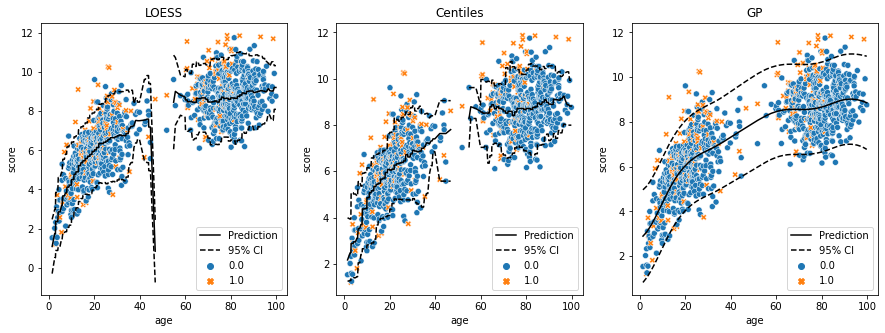

In [5]:
# Plot the data, model prediction, & 95% confidence interval
m_gap.plot()

## **Example 2**
In this example we'll look at a dataset with multivariate confounds (age, sex, and site) in addition to the basic score and group columns. The GP model can take an arbitrary number of confounds, in contrast to the LOESS & Centiles model which take only one. We'll compare the deviance scores from the three model to illustrate the advantage brought by the GP.

Here we are using a dataset with:
- Multiple confounds (explanatory variables) (age, sex & site)
- Homoskedastic variance across the explanatory variable within each site
- Gaussian noise
- A random offset in score for probands pulled from the gaussian distribution
- A random offset in score for sex pulled from the gaussian distribution
- A random offset in score for site pulled from the gaussian distribution (constant for all subjects from same site)

In [6]:
def g(age, sex, offset, prob = False):
    noise = np.random.normal(0, 0.1)
    if prob:
        return 0.001*age-0.00001*(age-50)**2+0.5 + noise - np.random.uniform(0, 0.3) * sex - 0.2 * np.random.uniform() + offset
    else:
        return 0.001*age-0.00001*(age-50)**2+0.5 + noise - np.random.uniform(0, 0.3) * sex + offset

def dataset_multivariate(n_sites=5,sample_size=35,seed=650):
    np.random.seed(seed)
    n_sites = n_sites
    age_min = (np.random.rand(n_sites)*50).astype(int)
    sites = pd.DataFrame(data={'sex_ratio': np.random.rand(n_sites),
                               'prob_ratio': 0.5*np.random.rand(n_sites),
                               'age_min': age_min,
                               'age_max': (age_min+5+np.random.rand(n_sites)*50).astype(int),
                               'score_shift': np.random.randn(n_sites)/4,
                               'sample_size': (sample_size+np.random.rand(n_sites)*sample_size*10).astype(int)})

    participants = []
    for site in sites.iterrows():
        for participant in range(int(site[1]['sample_size'])):
            sex = np.random.binomial(1, site[1]['sex_ratio'])
            prob = np.random.binomial(1, site[1]['prob_ratio'])
            age = np.random.uniform(site[1]['age_min'], site[1]['age_max'])
            score = g(age, sex, site[1]['score_shift'],prob=prob)
            participants.append([site[0], sex, prob, age, score])

    df = pd.DataFrame(participants, columns=['site', 'sex', 'status', 'age', 'score'])
    return df

In [7]:
# Create a dataset
df = dataset_multivariate()
df.head()

,site,sex,status,age,score
0,0,1,0,65.818713,0.409020
1,0,1,0,68.827045,0.294608
2,0,0,0,61.660016,0.313654
3,0,0,0,66.886592,0.423175
4,0,0,0,55.738248,0.257225


### Visualize data
Here we'll look at the data as we usually do (by PROB/CTR), but we'll also explore the effect of the confounds by looking at the data plotted by site and sex.

We've chosen to simulate a proband effect that causes a lower score, we can see this by eye when comparing the plots by PROB/CTR and by site - but we can expect the models that don't account for site to miss this effect as the site offsets overwhelm the effect.

Text(0.5, 1.0, 'By sex')

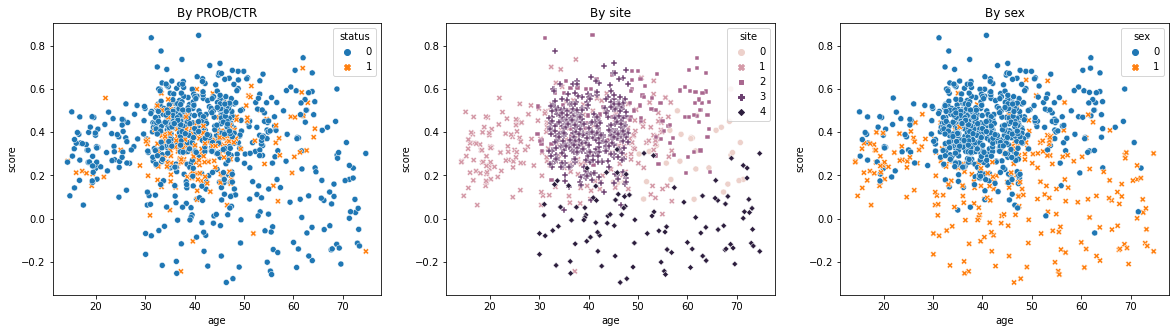

In [8]:
fig,ax = plt.subplots(1,3,figsize=(20,5))

sns.scatterplot(data=df, x='age', y='score', hue='status', style='status',ax=ax[0])
sns.scatterplot(data=df, x='age', y='score', hue='site', style='site',ax=ax[1])
sns.scatterplot(data=df, x='age', y='score', hue='sex', style='sex',ax=ax[2])

ax[0].set_title('By PROB/CTR')
ax[1].set_title('By site')
ax[2].set_title('By sex')

In the case of categorical confounds, it is useful to take a look at the distribution of the data within each category using violin plots. Here we can clearly see the offset in score associated with each site and sex. This will serve as a useful point of comparison when we take a look at the deviance scores from our models.

Text(0.5, 1.0, 'By sex')

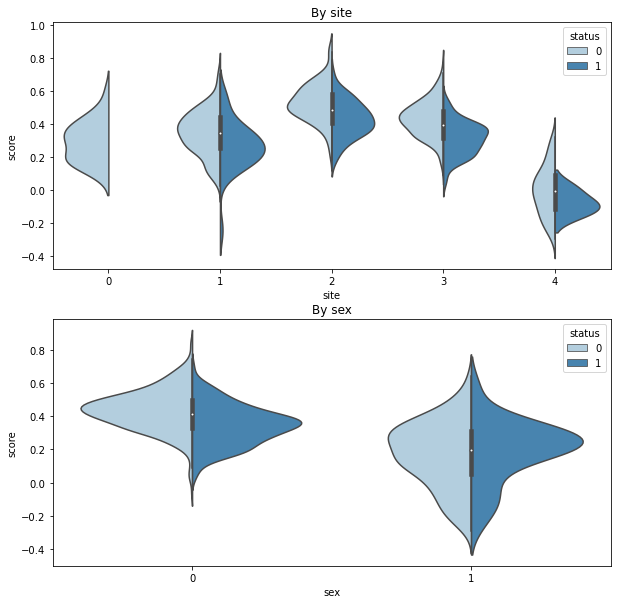

In [9]:
fig,ax = plt.subplots(2,1,figsize=(10,10))

sns.violinplot(x='site',y='score',data=df,split=True,palette='Blues',hue='status',ax=ax[0])
sns.violinplot(x='sex',y='score',data=df,split=True,palette='Blues',hue='status',ax=ax[1])

ax[0].set_title('By site')
ax[1].set_title('By sex')

### Fit GP model with multivariate confounds

In [10]:
# Initialize pynm w/ data, confounds, & bin parameters
m = PyNM(df,'score','status',['age','c(sex)','c(site)'],
        bin_width=7, bin_spacing=1)

Models will be fit on full set of controls.


In [11]:
# Run models
m.loess_normative_model()
m.centiles_normative_model()
m.gp_normative_model()

/home/harveyaa/miniconda3/envs/GPyTorch/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


The first obvious characteristic of the GP model is that the plot is a mess. Since it is using more information than is possible to represent in the 2D plot of score vs age it is not simple to visualize, but we can see that it can capture more trends in the data than the LOESS & Centiles models which make a simple prediction in each bin.

In this scenario it is much more informative to look at the plot of the deviance scores for each of the categorical variables. We can see that the GP model corrects beautifully for the site and sex (deviance scores centered about 0), whereas the LOESS & Centiles models are offset. 

In the plot of deviance scores against the age confound it's not only clear that the GP corrects well for age, but also that the difference between probands and controls becomes clear when the confounds are well modeled.

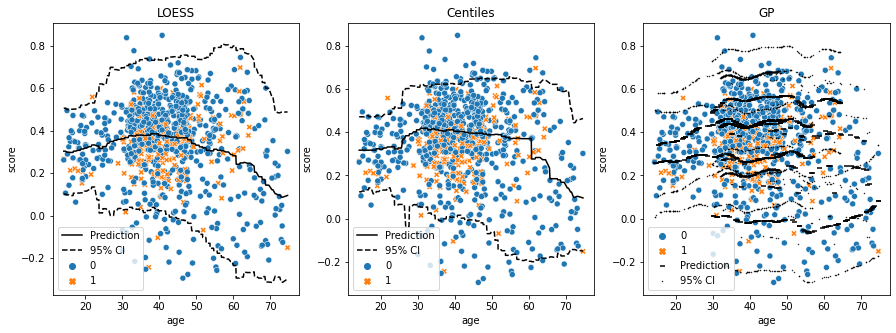

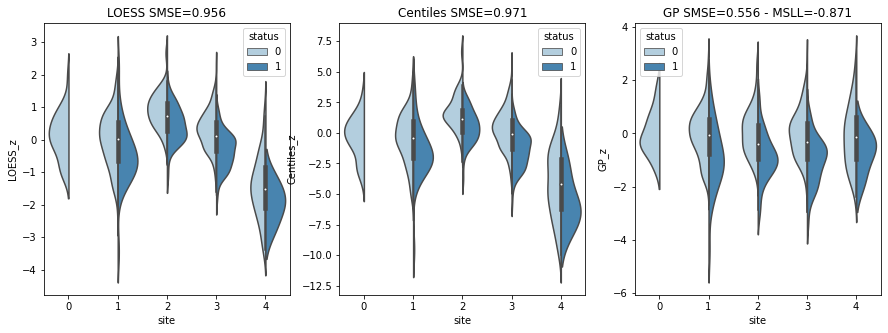

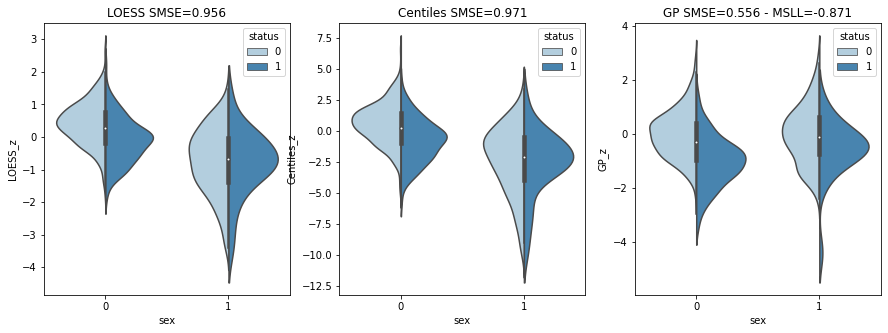

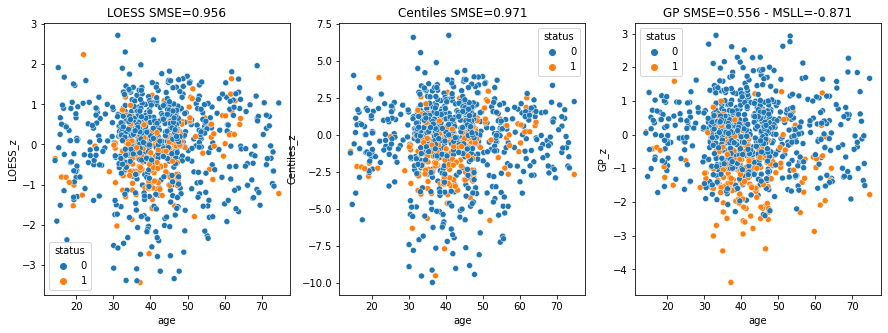

In [12]:
# Plot the data, model prediction, & 95% confidence interval
m.plot()

# Plot the z-scores of the model (model residuals / std deviation)
m.plot_z(confound='site')
m.plot_z(confound='sex')
m.plot_z(confound='age')

## **Example 3**
In this example we'll look at a simple dataset that violates the homoskedasticity and gaussian noise assumptions.

Here we are using a dataset with:
- A single explanatory variable (age)
- Heteroskedastic variance across the explanatory variable
- Non-gaussian noise
- A random offset in score for probands pulled from the gaussian distribution

In [13]:
# Define functions
def hetero_sin_noise(x):
    return 3*np.sin(0.05*x)*np.random.randn() + sp.skewnorm.rvs(a=2,size=1)[0]


def dataset_heteroskedastic(low=1,high=100,n_subs=1000,sampling='full',seed=888):
    np.random.seed(seed)
    x = sample_x(low=low,high=high,n_subs=n_subs,sampling=sampling)

    # PROB = 1/CTR = 0
    status = np.random.binomial(1,0.07,size=x.shape[0])

    # Score param
    score = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        s = 5 + hetero_sin_noise(x[i])

        # Random offset for probands
        s = s + status[i]*np.random.normal(0.7,1)

        score[i] = s

    df = pd.DataFrame([x,score,status],index=['age','score','status']).transpose()
    return df

In [14]:
# Create a dataset
df_het = dataset_heteroskedastic()
df_het.head()

,age,score,status
0,86.096500,6.546667,0.0
1,17.292380,4.395376,1.0
2,48.864120,4.275272,0.0
3,92.181699,4.362332,1.0
4,43.427088,6.529171,0.0


### Visualize data

<AxesSubplot:xlabel='age', ylabel='score'>

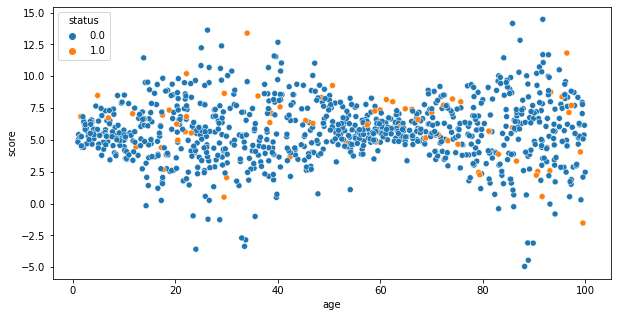

In [15]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='age',y='score',hue='status',data=df_het)

### Fit GP model on heteroskedastic data

In [16]:
# Initialize pynm w/ data, confounds, & bin parameters
m_het = PyNM(df_het,'score','status',['age'],
                bin_width=7, bin_spacing=1)

Models will be fit on full set of controls.


In [17]:
# Run models
m_het.loess_normative_model()
m_het.centiles_normative_model()
m_het.gp_normative_model()

/home/harveyaa/Documents/masters/PyNM/pynm/pynm.py:509: UserWarning: The residuals are not Gaussian!
  warnings.warn("The residuals are not Gaussian!")
/home/harveyaa/Documents/masters/PyNM/pynm/pynm.py:515: UserWarning: The residuals are heteroskedastic!
  warnings.warn("The residuals are heteroskedastic!")


First, we get warnings from the GP model that the residuals are not Gaussian and heteroskedastic. These warnings are meant to be a safeguard, but they shouldn't be totally relied upon as they are implementing simple tests that don't apply in every scenario.

We can see that the GP model fit is nonsensical, but there are two things happening at the same time. The first is that the model is overfitting the training data, we'll use this as an opportunity to explore the `length_scale` and `length_scale_bounds` parameters and discuss the second issue afterwards.

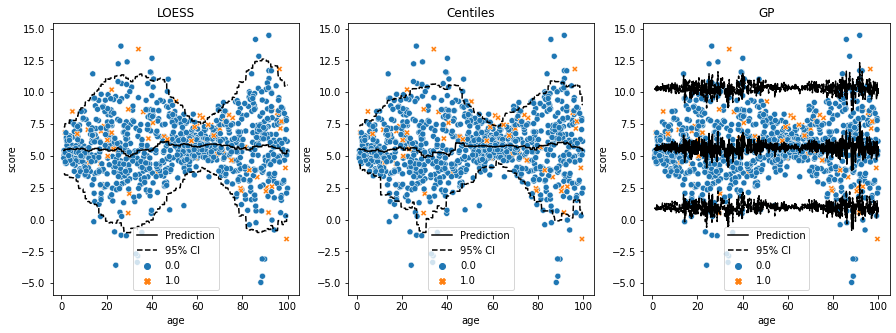

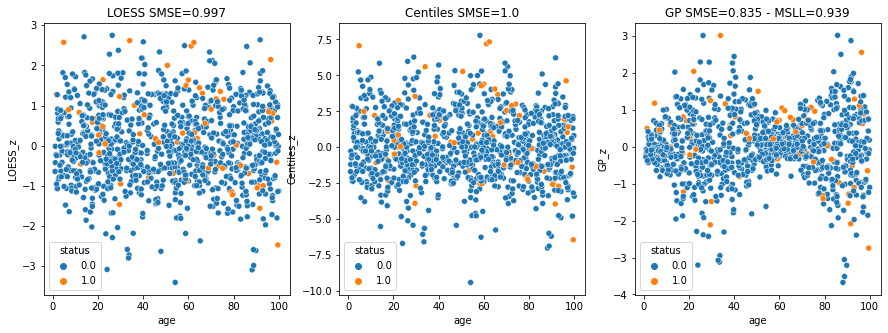

In [18]:
# Plot the data, model prediction, & 95% confidence interval
m_het.plot()

# Plot the z-scores of the model (model residuals / std deviation)
m_het.plot_z(confound='age')

### Fit GP model with fixed `length_scale`
The length scale determines how rapidly we expect the function to be changing - so a larger value implies a smoother function. By default, the `length_scale`=1 is passed to the GP model and the underlying kernel, and the algorithm that fits the model does it's own hyperparameter tuning within the range of `length_scale_bounds` to find the `length_scale` it determines is best suited to the data. In this scenario, it has chosen a `length_scale` that is much too small, so we will pass a larger value and set `length_scale_bounds` to 'fixed' to prevent further hyperparameter tuning. Note: `length_scale_bounds` can be set to 'fixed' or a pair of floats >=0, the default bounds are `(1e-5,1e5)`.

In [19]:
m_het.gp_normative_model(length_scale_bounds='fixed',length_scale=20)

/home/harveyaa/Documents/masters/PyNM/pynm/pynm.py:509: UserWarning: The residuals are not Gaussian!
  warnings.warn("The residuals are not Gaussian!")
/home/harveyaa/Documents/masters/PyNM/pynm/pynm.py:515: UserWarning: The residuals are heteroskedastic!
  warnings.warn("The residuals are heteroskedastic!")


Now that we've solved our first issue, we can see that the GP fails to accurately estimate the CI for the heteroskedastic data! This results in skewed deviance scores which we can see in the plot below. LOESS & Centiles succeed better in this scenario as they fit many local models (one in each bin) and don't need to assume homoskedasticity over the range of the data.

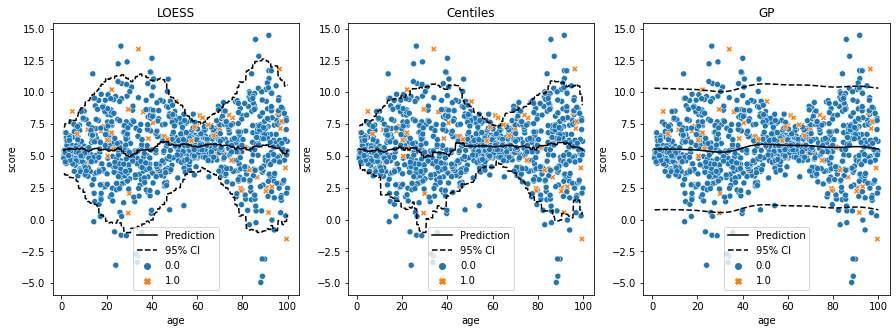

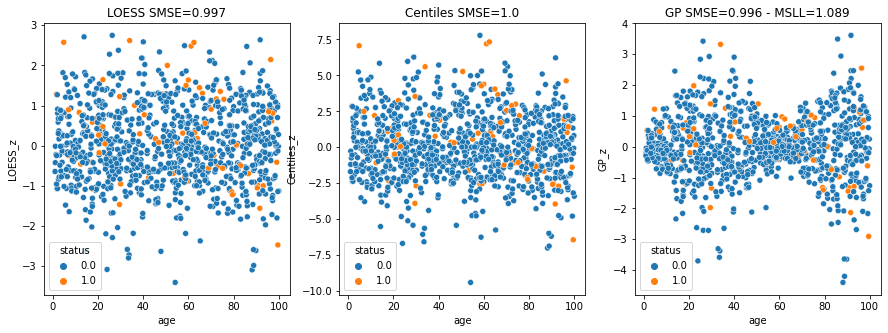

In [20]:
# Plot the data, model prediction, & 95% confidence interval
m_het.plot()

# Plot the z-scores of the model (model residuals / std deviation)
m_het.plot_z(confound='age')

## **Full GP model outputs**
We can explore the full outputs of the GP model by accessing the `data` attribute of the PyNM object. In general, all model outputs will be added as columns to the PyNM dataframe or as attributes to the PyNM object.

We won't look at the rest of the columns in `data` since they were covered in tutorial 1.

In [21]:
GP_cols = [col for col in m.data.columns if 'GP' in col]
m.data[GP_cols].head()

,GP_pred,GP_sigma,GP_residuals,GP_z
0,0.243982,0.119423,0.165038,1.381964
1,0.236600,0.119228,0.058007,0.486527
2,0.393704,0.118626,-0.080051,-0.674814
3,0.387562,0.120397,0.035613,0.295797
4,0.352835,0.118541,-0.095610,-0.806555


### Description of columns
- GP_pred
    - Prediction of the LOESS model (mean of predictive distribution).
- GP_sigma
    - Standard deviation of the GP model (std of predictive distribution).
- GP_residuals
    - Difference between actual value of score and GP_pred.
- GP_z
    - GP_residuals / GP_sigma.

## **Summary**
- The GP model handles missing data well.
- The GP model can model an arbitrary number of confounds.
- Plotting the deviance scores for each of the categorical variables is a good check.
- Data must meet the GP model assumptions (notably homoskedasticity and gaussian noise) in order for the model to be reliable.
- We can use the `length_scale` and `length_scale_bounds` parameters of the GP model to adjust the model fit.

## **Resources**
- Kilian Weinberger's [Cornell lecture](https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote15.html)
- A Visual Guide to Gaussian Processes on [distill](https://distill.pub/2019/visual-exploration-gaussian-processes/)
- Sklearn's Gaussian Proccesses [documentation](https://scikit-learn.org/stable/modules/gaussian_process.html)
- Xu et al. bioRxiv 2021, [The pitfalls of using Gaussian Process Regression for normative modeling](https://doi.org/10.1101/2021.05.11.443565)

### **Next up:** Normative modeling on big datasets using the Stochastic Variational Gaussian Process model!